In [41]:
# Importando pacotes necessários
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model





In [5]:
## Utilizar esse caso esteja usando o Google Colab

#from google.colab import drive
#drive.mount('/content/drive')

#Carregar arquivo do drive
#df = pd.read_csv('/content/drive/MyDrive/Períodos/2024-2/Aprendizado de Máquina/Projeto/dados.csv')

In [42]:
# Carregar o arquivo 'dados.csv' no dataframe
df = pd.read_csv('dados.csv')

# Exibir as primeiras linhas do dataframe para verificar se foi carregado corretamente
print(df.head())

   Qtd_Moradores  Maquina_de_Lavar_1  Geladeiras_1  Freezer_1  \
0            3.0                 0.0           1.0        0.0   
1            2.0                 0.0           1.0        1.0   
2            2.0                 0.0           1.0        0.0   
3            2.0                 1.0           1.0        1.0   
4            2.0                 1.0           1.0        1.0   

   Microcomputador  Lava_Loucas_1  Microondas_1  Ar_Condicionado  Televisao  \
0              0.0            0.0           0.0              0.0        1.0   
1              1.0            0.0           0.0              0.0        2.0   
2              0.0            0.0           0.0              0.0        1.0   
3              1.0            0.0           1.0              1.0        2.0   
4              1.0            0.0           1.0              0.0        2.0   

   Batedeira  ...  Secadora_Centrifuga  Aquecedor_de_Ambiente  \
0        1.0  ...                  0.0                    0.0   
1   

In [43]:
# Criar um dicionário de mapeamento
classe_map = {1: 'A', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2', 6: 'DE'}

# Substituir os valores da coluna 'CLASSE'
df['CLASSE'] = df['CLASSE'].map(classe_map)

# Verificar a alteração
print(df['CLASSE'].unique())

['C1' 'C2' 'DE' 'B2' 'B1' 'A']


In [44]:
contagem = df['CLASSE'].value_counts()
print(contagem)


CLASSE
C1    293
C2    262
B2    250
DE    176
B1     75
A      40
Name: count, dtype: int64


Aplicando o PCA

In [45]:
# Separar as variáveis independentes (X) e a variável dependente (y)
dados_sem_classe = df.drop('CLASSE', axis=1)
classe_1 = df['CLASSE']

In [46]:
# Padronizar os dados antes de aplicar o PCA
scaler = StandardScaler()
dadosPCA_scaled = scaler.fit_transform(dados_sem_classe)

In [47]:
# Aplicar PCA
pca = PCA()
dadosPCA_reduced = pca.fit_transform(dadosPCA_scaled)

In [48]:
# Variância explicada por cada componente
explained_variance = pca.explained_variance_ratio_

In [49]:
# Variância acumulada
cumulative_variance = np.cumsum(explained_variance)

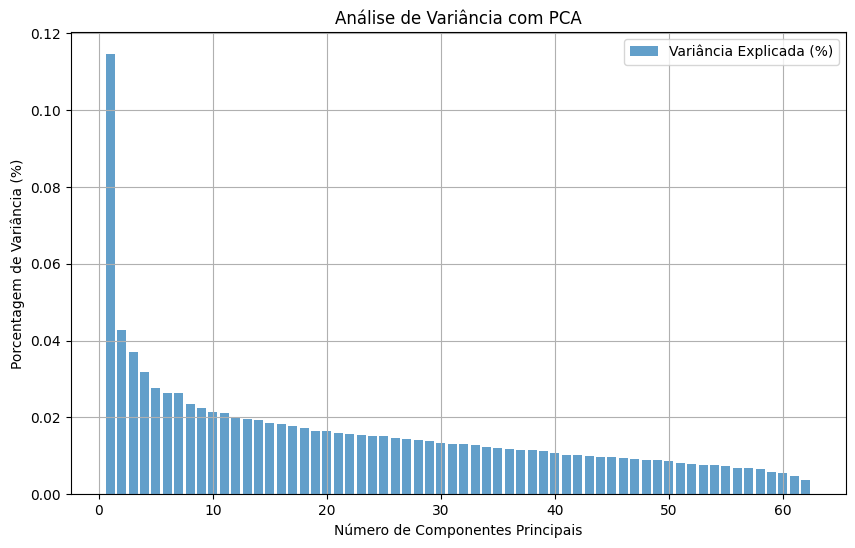

In [50]:
# Plotar a variância explicada e a acumulada em gráficos de barras
plt.figure(figsize=(10, 6))

# Gráfico de barras para a variância explicada
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Variância Explicada (%)')
plt.title('Análise de Variância com PCA')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Porcentagem de Variância (%)')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [51]:
# Encontrar o número de componentes que explicam
n_components = np.argmax(cumulative_variance >= 0.8) + 1

print(f"Número de componentes principais: {n_components}")

Número de componentes principais: 38


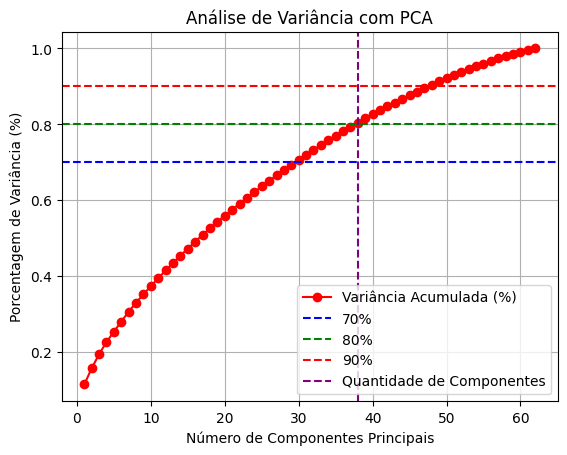

In [52]:
# Gráfico de linha para a variância acumulada
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='red', label='Variância Acumulada (%)')
plt.title('Análise de Variância com PCA')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Porcentagem de Variância (%)')

plt.axhline(y=0.70, color='blue', linestyle='--', linewidth=1.5, label='70%')
plt.axhline(y=0.80, color='green', linestyle='--', linewidth=1.5, label='80%')
plt.axhline(y=0.90, color='red', linestyle='--', linewidth=1.5, label='90%')


plt.axvline(x=n_components, color='purple', linestyle='--', linewidth=1.5, label='Quantidade de Componentes')


plt.legend(loc='best')
plt.grid(True)
plt.show()

In [53]:
# Aplicar PCA com o número de componentes selecionados
pca = PCA(n_components=n_components)
dadosPCA_reduced = pca.fit_transform(dadosPCA_scaled)

In [54]:
# Criar um DataFrame com as componentes principais
df_pca = pd.DataFrame(dadosPCA_reduced, columns=[f'PC{i+1}' for i in range(n_components)])


In [55]:
# Adicionar a coluna da variável alvo
df_pca['CLASSE'] = classe_1.reset_index(drop=True)


In [ ]:
#Dataframe criado com as componentes principais

df_pca.head()

O PCA selecionou 38 componentes para explicar 80% dos dados. Será criado outro dataframe que seleciona as variáveis mais correlatadas com a primeira componente principal.

In [56]:
#Correlacao Selecionada, acima de:

corre = 0.4

In [57]:
# Ajustar o PCA aos dados e calcular as componentes principais
pca_components = dadosPCA_reduced.copy()

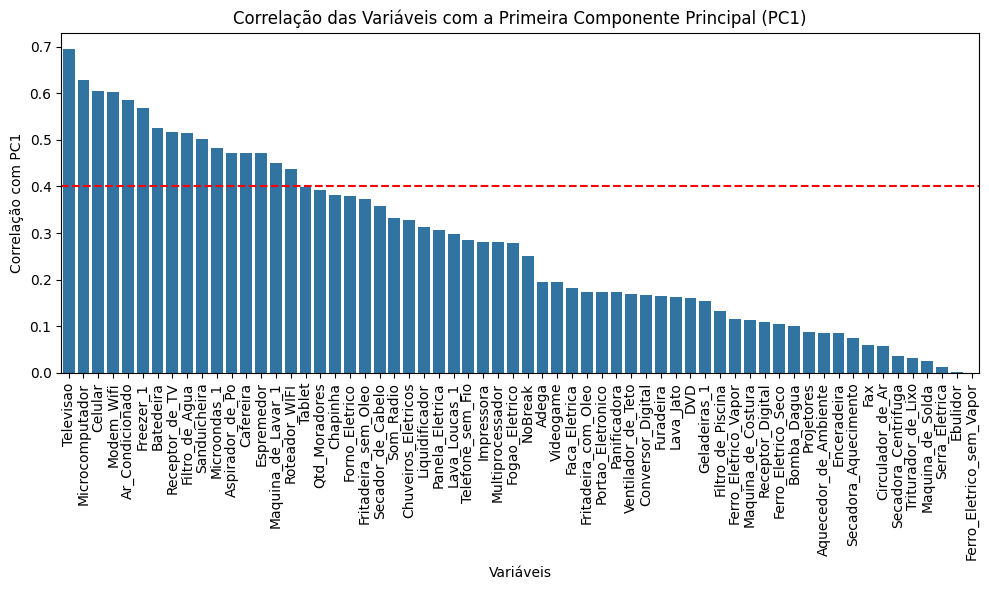

In [58]:
# Calcular a correlação entre as variáveis originais e a primeira componente principal pela correlação de spearman
corr_with_PC1 = dados_sem_classe.apply(lambda x: x.corr(pd.Series(pca_components[:, 0]), method='spearman'))

# Ordenar as variáveis por correlação absoluta com a primeira componente principal
corr_with_PC1_sorted = corr_with_PC1.abs().sort_values(ascending=False)

# Criar um gráfico de barras para visualizar as correlações
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_with_PC1_sorted.index, y=corr_with_PC1_sorted.values)
plt.xticks(rotation=90)
plt.xlabel('Variáveis')
plt.ylabel('Correlação com PC1')
plt.title('Correlação das Variáveis com a Primeira Componente Principal (PC1)')
plt.axhline(y=corre, color='red', linestyle='--', linewidth=1.5)
plt.tight_layout()
plt.show()

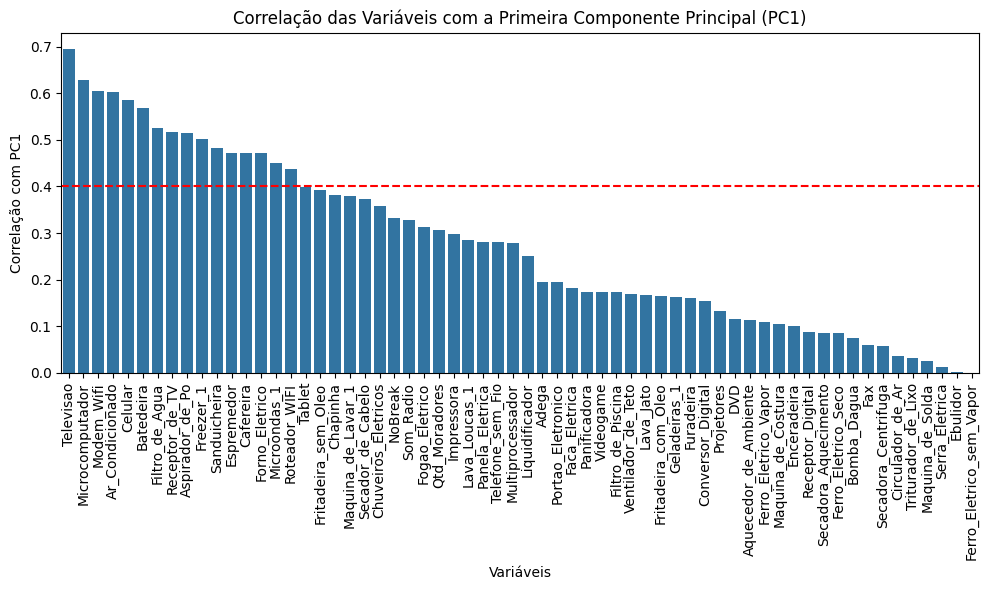

In [59]:
# Calcular a correlação entre as variáveis originais e a primeira componente principal pela correlação de Pearson
corr2_with_PC1 = dados_sem_classe.apply(lambda x: x.corr(pd.Series(pca_components[:, 0]), method='pearson'))

# Ordenar as variáveis por correlação absoluta com a primeira componente principal
corr2_with_PC1_sorted = corr2_with_PC1.abs().sort_values(ascending=False)

# Criar um gráfico de barras para visualizar as correlações
plt.figure(figsize=(10, 6))
sns.barplot(x=corr2_with_PC1_sorted.index, y=corr_with_PC1_sorted.values)
plt.xticks(rotation=90)
plt.xlabel('Variáveis')
plt.ylabel('Correlação com PC1')
plt.title('Correlação das Variáveis com a Primeira Componente Principal (PC1)')
plt.axhline(y=corre, color='red', linestyle='--', linewidth=1.5)
plt.tight_layout()
plt.show()

In [60]:
# Filtrar variáveis com maior correlação
selected_vars = corr_with_PC1_sorted[corr_with_PC1_sorted > corre].index

In [61]:
# Criar um novo dataframe com as variáveis selecionadas
df_selected = dados_sem_classe[selected_vars].copy()

# Adicionar a coluna CLASSE ao novo dataframe
df_selected['CLASSE'] = classe_1.reset_index(drop=True)

In [62]:
#Novo dataframe com as variaveis mais correlatadas com a primeira componente principal

df_selected.head()
#print(df_selected.shape)

,Televisao,Microcomputador,Celular,Modem_Wifi,Ar_Condicionado,Freezer_1,Batedeira,Receptor_de_TV,Filtro_de_Agua,Sanduicheira,Microondas_1,Aspirador_de_Po,Cafereira,Espremedor,Maquina_de_Lavar_1,Roteador_WIFI,CLASSE
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,C1
1,2.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C2
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DE
3,2.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,B2
4,2.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,C1


Aplicando redução pelo coeficiente de spearman

In [30]:
# Calcular a correlação de Spearman para as variáveis
spearman_corr = dados_sem_classe.corr(method='spearman')

In [29]:
# Definir um limiar (threshold) para selecionar as variáveis com alta correlação
threshold = 0.3

In [30]:
# Selecionar as variáveis mais correlacionadas
correlated_vars = np.where(np.abs(spearman_corr) > threshold)
correlated_vars = [(spearman_corr.index[x], spearman_corr.columns[y]) for x, y in zip(*correlated_vars) if x != y]

In [ ]:
# Exibir a matriz de correlação
spearman_corr

In [ ]:
# Plotar o heatmap da matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação (Spearman)')
plt.show()

In [33]:
# Remover duplicatas e manter uma cópia da variável apenas
selected_columns = list(set([var[0] for var in correlated_vars]))

In [34]:
# Criar um novo dataframe com essas variáveis correlacionadas
df_spearman = dados_sem_classe[selected_columns].copy()


In [35]:
# Adicionar a coluna da variável alvo
df_spearman['CLASSE'] = classe_1.reset_index(drop=True)


In [ ]:
# Exibir as primeiras linhas do novo DataFrame
df_spearman.head()

O algoritmo não encontrou variáveis correlatadas com mais de 70%, por isso será criado um dataframe com as variáveis que possuem maior correlação com as variáveis de saída.

In [37]:
#Correlação a ser selecionada

cor = 0.3

In [ ]:
# Calcular a correlação de Spearman entre as variáveis de entrada e a variável de saída
spearman_corr_with_target = dados_sem_classe.apply(lambda x: x.corr(classe_1, method='spearman'))

# Ordenar as variáveis por ordem de correlação (absoluta) com a variável de saída
spearman_corr_with_target = spearman_corr_with_target.abs().sort_values(ascending=False)

# Exibir a correlação de cada variável de entrada com a variável de saída
print(spearman_corr_with_target)


In [ ]:
# Filtrar as variáveis que têm maior correlação
selected_features = spearman_corr_with_target[spearman_corr_with_target > cor].index

# Criar um novo DataFrame apenas com essas variáveis
df_high_corr = dados_sem_classe[selected_features].copy()

# Adicionar a coluna da variável alvo
df_high_corr['CLASSE'] = classe_1.reset_index(drop=True)

In [ ]:
# Exibir as primeiras linhas do novo DataFrame feito a partir das variáveis de entrada mais correlatadas com as variáveis de saída
df_high_corr.head()

DataFrames criados até aqui:

df_pca - Componentes principais
df_selected - Variaveis com maior correlacao com a Primeira Componente Principal
df_spearman - Remoção das variáveis mais correlatadas
df_high_corr - Variaveis de entrada com maior correlação com as variáveis de saída

Aplicando a seleção de Dados por k-fold

In [63]:
#Selecionando o dataframe

df_kfold = df_pca.copy()
#df_kfold = df_selected.copy()
#df_kfold = df_spearman.copy()
#df_kfold = df_high_corr.copy()

In [64]:
# Separando as variáveis objetivo
X = df_kfold.drop('CLASSE', axis=1)
y = df_kfold['CLASSE']


In [65]:
#Definindo o número de folds

num_folds = 7
sub_num_folds = 7

In [69]:
#Configurar o k-Fold Principal

kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [70]:
#Dividir os Dados para o k-fold teste

fold_indices = list(kf.split(X, y))

In [74]:
# Iterar sobre cada fold principal
for fold, (train_index, test_index) in enumerate(fold_indices):
    # Dados de treino e teste para o fold principal
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Aplicar o sub-k-fold para treino e validação
    sub_kf = StratifiedKFold(n_splits=sub_num_folds, shuffle=True, random_state=42)

    # Armazenar os índices dos folds secundários
    sub_fold_indices = list(sub_kf.split(X_train, y_train))

    for sub_fold, (sub_train_index, sub_val_index) in enumerate(sub_fold_indices):
        # Dados de treino e validação para o sub-k-fold
        X_sub_train, X_sub_val = X_train.iloc[sub_train_index], X_train.iloc[sub_val_index]
        y_sub_train, y_sub_val = y_train.iloc[sub_train_index], y_train.iloc[sub_val_index]

        # Aqui você pode treinar e validar seu modelo
        # Exemplo: print(f'Fold {fold + 1}, Sub-Fold {sub_fold + 1}')


Testando disposição das Classes

In [82]:
from collections import Counter
import pandas as pd

# Exemplo de dataframe com rótulos (alvo)
y = pd.Series(y)  # Supondo que seus rótulos estejam em um array ou lista chamada 'y'

# Inicializar o StratifiedKFold
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

# Iterar pelos folds principais
for fold, (train_index, test_index) in enumerate(kfold.split(X, y)):
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Contagem das classes no treino e teste
    train_counts = Counter(y_train)
    test_counts = Counter(y_test)
    
    print(f"Fold {fold + 1}")
    print(f"Distribuição no treino: {train_counts}")
    print(f"Distribuição no teste: {test_counts}\n")


Fold 1
Distribuição no treino: Counter({'C1': 251, 'C2': 224, 'B2': 214, 'DE': 151, 'B1': 65, 'A': 34})
Distribuição no teste: Counter({'C1': 42, 'C2': 38, 'B2': 36, 'DE': 25, 'B1': 10, 'A': 6})

Fold 2
Distribuição no treino: Counter({'C1': 251, 'C2': 224, 'B2': 215, 'DE': 151, 'B1': 64, 'A': 34})
Distribuição no teste: Counter({'C1': 42, 'C2': 38, 'B2': 35, 'DE': 25, 'B1': 11, 'A': 6})

Fold 3
Distribuição no treino: Counter({'C1': 251, 'C2': 225, 'B2': 215, 'DE': 150, 'B1': 64, 'A': 34})
Distribuição no teste: Counter({'C1': 42, 'C2': 37, 'B2': 35, 'DE': 26, 'B1': 11, 'A': 6})

Fold 4
Distribuição no treino: Counter({'C1': 251, 'C2': 225, 'B2': 214, 'DE': 151, 'B1': 64, 'A': 34})
Distribuição no teste: Counter({'C1': 42, 'C2': 37, 'B2': 36, 'DE': 25, 'B1': 11, 'A': 6})

Fold 5
Distribuição no treino: Counter({'C1': 251, 'C2': 225, 'B2': 214, 'DE': 151, 'B1': 64, 'A': 35})
Distribuição no teste: Counter({'C1': 42, 'C2': 37, 'B2': 36, 'DE': 25, 'B1': 11, 'A': 5})

Fold 6
Distribuição 

In [84]:
from collections import Counter
import pandas as pd
from sklearn.model_selection import StratifiedKFold

# Suponha que X seja um DataFrame e y seja uma Series
# Se X é um DataFrame e y é uma Series
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

# Iterar pelos folds principais
for fold, (train_index, test_index) in enumerate(kfold.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Contagem das classes no treino e teste
    train_counts = Counter(y_train)
    test_counts = Counter(y_test)
    
    print(f"Fold {fold + 1}")
    print(f"Distribuição no treino: {train_counts}")
    print(f"Distribuição no teste: {test_counts}\n")

    # Subdividir o treino em subfolds
    sub_kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
    
    for sub_fold, (sub_train_index, sub_val_index) in enumerate(sub_kfold.split(X_train, y_train)):
        y_sub_train = y_train.iloc[sub_train_index]
        y_sub_val = y_train.iloc[sub_val_index]
        
        # Contagem das classes nos subfolds
        sub_train_counts = Counter(y_sub_train)
        sub_val_counts = Counter(y_sub_val)
        
        print(f"  Subfold {sub_fold + 1}")
        print(f"  Distribuição no treino: {sub_train_counts}")
        print(f"  Distribuição na validação: {sub_val_counts}\n")



Fold 1
Distribuição no treino: Counter({'C1': 251, 'C2': 224, 'B2': 214, 'DE': 151, 'B1': 65, 'A': 34})
Distribuição no teste: Counter({'C1': 42, 'C2': 38, 'B2': 36, 'DE': 25, 'B1': 10, 'A': 6})

  Subfold 1
  Distribuição no treino: Counter({'C1': 215, 'C2': 192, 'B2': 183, 'DE': 130, 'B1': 55, 'A': 29})
  Distribuição na validação: Counter({'C1': 36, 'C2': 32, 'B2': 31, 'DE': 21, 'B1': 10, 'A': 5})

  Subfold 2
  Distribuição no treino: Counter({'C1': 215, 'C2': 192, 'B2': 183, 'DE': 130, 'B1': 55, 'A': 30})
  Distribuição na validação: Counter({'C1': 36, 'C2': 32, 'B2': 31, 'DE': 21, 'B1': 10, 'A': 4})

  Subfold 3
  Distribuição no treino: Counter({'C1': 215, 'C2': 192, 'B2': 183, 'DE': 130, 'B1': 56, 'A': 29})
  Distribuição na validação: Counter({'C1': 36, 'C2': 32, 'B2': 31, 'DE': 21, 'B1': 9, 'A': 5})

  Subfold 4
  Distribuição no treino: Counter({'C1': 215, 'C2': 192, 'B2': 184, 'DE': 129, 'B1': 56, 'A': 29})
  Distribuição na validação: Counter({'C1': 36, 'C2': 32, 'B2': 30,

Aplicando as redes neurais no k-fold

In [85]:
# Função para criar o modelo de rede neural
def create_model(input_shape, num_classes):
    model = Sequential([
        Dense(12, activation='relu', input_shape=(input_shape,)),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [86]:
# Lista para armazenar as métricas de avaliação
validation_reports = []

In [87]:
best_model_path = 'best_model.keras'  # Local para salvar o melhor modelo

# Configurar o callback para salvar o melhor modelo com base na métrica de validação
checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True, mode='max')

# Variável para armazenar o melhor desempenho
best_val_accuracy = 0
best_fold = None

In [93]:
# Inicializar uma lista para armazenar a precisão ponderada de cada fold
fold_accuracies = []

In [94]:
# Codificar os rótulos para garantir que estejam no intervalo esperado
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Aplicar k-Fold e Sub-K-Fold
for fold, (train_index, test_index) in enumerate(fold_indices):
    # Dados de treino e teste para o fold principal
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Aplicar Sub-K-Fold para treino e validação
    sub_fold_indices = list(sub_kf.split(X_train, y_train))
    
    for sub_fold, (sub_train_index, sub_val_index) in enumerate(sub_fold_indices):
        # Dados de treino e validação para o sub-k-fold
        X_sub_train, X_sub_val = X_train.iloc[sub_train_index], X_train.iloc[sub_val_index]
        y_sub_train, y_sub_val = y_train[sub_train_index], y_train[sub_val_index]
        
        # Criar o modelo
        num_classes = len(label_encoder.classes_)
        model = create_model(X.shape[1], num_classes)
        
        # Treinar o modelo e salvar o histórico
        history = model.fit(
            X_sub_train, y_sub_train, 
            epochs=100, batch_size=32, 
            verbose=0, validation_data=(X_sub_val, y_sub_val),
            callbacks=[checkpoint]
        )

        # Avaliar no conjunto de teste
        y_test_pred = model.predict(X_test)
        y_test_pred_classes = np.argmax(y_test_pred, axis=1)
        
        # Calcular acurácia de teste
        test_accuracy = np.mean(y_test_pred_classes == y_test)

        # Adicionar a precisão ao dicionário de precisões dos folds
        fold_accuracies.append({
            'fold': fold,
            'sub_fold': sub_fold,
            'test_accuracy': test_accuracy
        })

        # Atualizar o melhor modelo se este fold for melhor
        if test_accuracy > best_val_accuracy:
            best_val_accuracy = test_accuracy
            best_fold = (fold, sub_fold)
        
        # # Plotar o gráfico de perda (loss) e acurácia (accuracy)
        # plt.figure(figsize=(12, 5))

        # # Perda (loss)
        # plt.subplot(1, 2, 1)
        # plt.plot(history.history['loss'], label='Train Loss')
        # plt.plot(history.history['val_loss'], label='Validation Loss')
        # plt.title(f'Fold {fold + 1} Sub-Fold {sub_fold + 1} - Loss')
        # plt.xlabel('Epochs')
        # plt.ylabel('Loss')
        # plt.legend()

        # # Acurácia (accuracy)
        # plt.subplot(1, 2, 2)
        # plt.plot(history.history['accuracy'], label='Train Accuracy')
        # plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        # plt.title(f'Fold {fold + 1} Sub-Fold {sub_fold + 1} - Accuracy')
        # plt.xlabel('Epochs')
        # plt.ylabel('Accuracy')
        # plt.legend()

        # # Mostrar o gráfico
        # plt.show()


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [95]:
# Exibir precisões ponderadas de cada fold
for accuracy in fold_accuracies:
    print(f"Fold {accuracy['fold']}, Sub-Fold {accuracy['sub_fold']}: Acurácia de Teste = {accuracy['test_accuracy']:.4f}")

Fold 0, Sub-Fold 0: Acurácia de Teste = 0.5605
Fold 0, Sub-Fold 1: Acurácia de Teste = 0.5096
Fold 0, Sub-Fold 2: Acurácia de Teste = 0.5096
Fold 0, Sub-Fold 3: Acurácia de Teste = 0.5669
Fold 0, Sub-Fold 4: Acurácia de Teste = 0.4586
Fold 0, Sub-Fold 5: Acurácia de Teste = 0.4968
Fold 0, Sub-Fold 6: Acurácia de Teste = 0.5414
Fold 1, Sub-Fold 0: Acurácia de Teste = 0.4968
Fold 1, Sub-Fold 1: Acurácia de Teste = 0.4777
Fold 1, Sub-Fold 2: Acurácia de Teste = 0.4650
Fold 1, Sub-Fold 3: Acurácia de Teste = 0.4522
Fold 1, Sub-Fold 4: Acurácia de Teste = 0.4904
Fold 1, Sub-Fold 5: Acurácia de Teste = 0.4459
Fold 1, Sub-Fold 6: Acurácia de Teste = 0.5159
Fold 2, Sub-Fold 0: Acurácia de Teste = 0.5541
Fold 2, Sub-Fold 1: Acurácia de Teste = 0.5032
Fold 2, Sub-Fold 2: Acurácia de Teste = 0.5096
Fold 2, Sub-Fold 3: Acurácia de Teste = 0.5732
Fold 2, Sub-Fold 4: Acurácia de Teste = 0.5924
Fold 2, Sub-Fold 5: Acurácia de Teste = 0.6178
Fold 2, Sub-Fold 6: Acurácia de Teste = 0.5032
Fold 3, Sub-F

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Melhor acurácia no fold 3, sub-fold 6: 0.6178343949044586


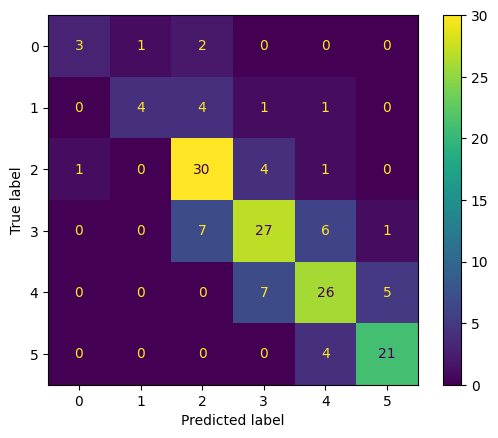

In [96]:
# Carregar o melhor modelo
best_model = load_model(best_model_path)

# Fazer previsões no conjunto de teste final
y_test_pred = best_model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Gerar a matriz de confusão
cm = confusion_matrix(y_test, y_test_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Exibir a acurácia final do melhor modelo
print(f"Melhor acurácia no fold {best_fold[0]+1}, sub-fold {best_fold[1]+1}: {best_val_accuracy}")

In [97]:
# Calcular a matriz de confusão original
conf_matrix = confusion_matrix(y_test, y_test_pred_classes)

# Frequência das classes no conjunto de dados
class_counts = np.bincount(y_test)  # Conta o número de ocorrências de cada classe
class_weights = 1.0 / class_counts  # Calcula o peso de cada classe

# Matriz de confusão ponderada
weighted_conf_matrix = conf_matrix * class_weights[:, np.newaxis]

# Exibir a matriz de confusão ponderada
print("Matriz de Confusão Ponderada:")
print(weighted_conf_matrix)

# Calcular a precisão de cada classe
precisions = []
for i in range(weighted_conf_matrix.shape[0]):
    true_positives = weighted_conf_matrix[i, i]  # Verdadeiros Positivos
    false_positives = sum(weighted_conf_matrix[:, i]) - true_positives  # Falsos Positivos
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    precisions.append(precision)

# Exibir a precisão de cada classe
for idx, precision in enumerate(precisions):
    print(f'Precisão da Classe {idx}: {precision:.4f}')


Matriz de Confusão Ponderada:
[[0.5        0.16666667 0.33333333 0.         0.         0.        ]
 [0.         0.4        0.4        0.1        0.1        0.        ]
 [0.02777778 0.         0.83333333 0.11111111 0.02777778 0.        ]
 [0.         0.         0.17073171 0.65853659 0.14634146 0.02439024]
 [0.         0.         0.         0.18421053 0.68421053 0.13157895]
 [0.         0.         0.         0.         0.16       0.84      ]]
Precisão da Classe 0: 0.9474
Precisão da Classe 1: 0.7059
Precisão da Classe 2: 0.4796
Precisão da Classe 3: 0.6249
Precisão da Classe 4: 0.6118
Precisão da Classe 5: 0.8434


In [99]:
from sklearn.metrics import confusion_matrix, precision_score

# Armazenar as precisões por classe para cada sub-fold
sub_fold_precisions = []

# Exibir a precisão de cada classe
for fold, (train_index, test_index) in enumerate(fold_indices):
    # Dados de treino e teste para o fold principal
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    # Aplicar Sub-K-Fold para treino e validação
    sub_fold_indices = list(sub_kf.split(X_train, y_train))
    
    for sub_fold, (sub_train_index, sub_val_index) in enumerate(sub_fold_indices):
        # Dados de treino e validação para o sub-k-fold
        X_sub_train, X_sub_val = X_train.iloc[sub_train_index], X_train.iloc[sub_val_index]
        y_sub_train, y_sub_val = y_train[sub_train_index], y_train[sub_val_index]
        
        # Criar o modelo
        num_classes = len(label_encoder.classes_)
        model = create_model(X.shape[1], num_classes)
        
        # Treinar o modelo e salvar o histórico
        history = model.fit(
            X_sub_train, y_sub_train, 
            epochs=100, batch_size=32, 
            verbose=0, validation_data=(X_sub_val, y_sub_val),
            callbacks=[checkpoint]
        )

        # Avaliar no conjunto de teste
        y_test_pred = model.predict(X_test)
        y_test_pred_classes = np.argmax(y_test_pred, axis=1)
        
        # Calcular a matriz de confusão
        cm = confusion_matrix(y_test, y_test_pred_classes, labels=np.arange(num_classes))
        
        # Calcular a precisão de cada classe
        class_precisions = precision_score(y_test, y_test_pred_classes, average=None)
        
        # Armazenar a precisão de cada classe para o sub-fold
        sub_fold_precisions.append({
            'fold': fold,
            'sub_fold': sub_fold,
            'precisions': class_precisions
        })

c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [100]:
# Exibir precisões de cada classe para cada sub-fold
for sub_fold_precision in sub_fold_precisions:
    print(f"Fold {sub_fold_precision['fold']}, Sub-Fold {sub_fold_precision['sub_fold']}:")
    for i, precision in enumerate(sub_fold_precision['precisions']):
        print(f"  Precisão da Classe {i}: {precision:.4f}")

Fold 0, Sub-Fold 0:
  Precisão da Classe 0: 0.5000
  Precisão da Classe 1: 0.7778
  Precisão da Classe 2: 0.4706
  Precisão da Classe 3: 0.4444
  Precisão da Classe 4: 0.5682
  Precisão da Classe 5: 0.6842
Fold 0, Sub-Fold 1:
  Precisão da Classe 0: 0.3333
  Precisão da Classe 1: 0.6667
  Precisão da Classe 2: 0.4750
  Precisão da Classe 3: 0.5455
  Precisão da Classe 4: 0.5897
  Precisão da Classe 5: 0.6818
Fold 0, Sub-Fold 2:
  Precisão da Classe 0: 0.3333
  Precisão da Classe 1: 0.5556
  Precisão da Classe 2: 0.5641
  Precisão da Classe 3: 0.4600
  Precisão da Classe 4: 0.6452
  Precisão da Classe 5: 0.6400
Fold 0, Sub-Fold 3:
  Precisão da Classe 0: 0.3333
  Precisão da Classe 1: 0.3333
  Precisão da Classe 2: 0.4359
  Precisão da Classe 3: 0.4130
  Precisão da Classe 4: 0.5476
  Precisão da Classe 5: 0.6667
Fold 0, Sub-Fold 4:
  Precisão da Classe 0: 0.5000
  Precisão da Classe 1: 0.5000
  Precisão da Classe 2: 0.3784
  Precisão da Classe 3: 0.4583
  Precisão da Classe 4: 0.5854
 